# Examples of utils provided by ReGraph's Neo4jHierarchy module

In [42]:
import networkx as nx
from regraph import Rule, plot_rule


from regraph.neo4j.hierarchy import Neo4jHierarchy
import regraph.neo4j.cypher_utils as cypher
from regraph.neo4j.rewriting_utils import propagate_down_v2

## Initializing Neo4j database

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [43]:
# initialize the neo4j driver, wrappped into Neo4jHierarchy object
h = Neo4jHierarchy(uri="bolt://localhost:7687", user="neo4j", password="admin")

In [44]:
h.clear()

## Hierarchy

A hierarchy is represented by at least 2 graphs with a typing relation (homorphism) between them.


Each graph in the database is represented by a unique label which enables us to match quickly the nodes of this graph. Each node of a graph has then the labels *node* and *graphLabel*. We can match these nodes by using the query:

> MATCH (n:node:graphLabel) RETURN n


The edges of a graph are labeled as *edge* and the typing edges are labeled as *typing*. We can then easily find the image of a node with the query:

> OPTIONAL MATCH (n:node:graphLabel)-[:typing]->(m) RETURN m

The hierarchy skeleton is represented by nodes labeled as hierarchyNodes. It enables us to know which graphs are the ancestors of a graph we want to rewrite for example.

## Adding a graph to the hierarchy (Action Graph)

Here we create a first graph called *ActionGraph*. This graph represent people and the relationship between them.

In [45]:
nodes = [
    ("a", {"name": {"Jack"}, "age": {43}, "hobby": {"hiking", "music"}}), 
    ("b", {"name": {"Robert"}, "age": {35}, "hobby": {"sport", "music"}, "height": {178}}),
    ("c", {"name":{ "Paul"}, "age": {18}}),
    ("d", {"name": {"Joe"}, "age": {10}}),
    ("e", {"name": {"Paul"}, "age": {18}})
]
edges = [
    ("a", "b", {"type": {"friends"}}), 
    ("a", "c", {"type": {"colleagues"}}),
    ("b", "c", {"type": {"colleagues"}}),
    ("d", "a", {"type": {"child_of"}}), 
    ("d", "e", {"type": {"enemies"}}),
    ("e", "e", {"type": {"likes"}})
]
h.add_graph('actionGraph', nodes, edges)

## Adding a second graph to the herarchy (Meta Model)

Here we create a second graph called *MetaModel*. Which represent the types of people (*Adult* or *Child*) and the relationships between them.

In [46]:
nodes = [
    ("a", {"type": {"Adult"}, "age": {43, 35, 18}}),
    ("b", {"type": {"Child"}, "age": {10, 11, 12, 18}, "name": {"Paul", "Joe"}})
]
edges = [
    ("a", "a", {"type": {"friends", "colleagues"}}),
    ("b", "a", {"type": {"child_of"}}),
    ("b", "b", {"type": {"friends", "enemies"}})
]
h.add_graph('metaModel', nodes, edges)

## Typing

Here we create a typing of the *ActionGraph* on the *MetaModel*.

In [47]:
mapping = {
    "a":"a",
    "b":"a",
    "c":"a",
    "d":"b",
    "e":"b"
}
h.add_typing('actionGraph', 'metaModel', mapping)

In [48]:
#h.check_typing('actionGraph', 'metaModel')

## Classic update functions

We still can use the modification functions on these grapphs.

In [49]:
#ag.merge_nodes1(["b", "c"])

In [50]:
#ag.clone_node("e")

## Graph rewriting and propagation up

In [51]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", ("y",  {"type": {"Child"}, "name" : {"Paul", "Joe"}})])
pattern.add_edges_from([("y", "x",  {"type": {"child_of"}}), ("y", "y")])

In [52]:
rule = Rule.from_transform(pattern)
rule.inject_remove_node_attrs("y",  {"name": {"Joe"}})
rule.inject_remove_edge_attrs("y", "x",  {"type": {"child_of"}})

In [53]:
rule.removed_node_attrs()  

{'y': {'name': <regraph.default.attribute_sets.FiniteSet at 0x7ff0ebbdba90>}}

In [54]:
from regraph.default.utils import normalize_attrs
arg = {'type':{'child'}}
normalize_attrs(arg)
print(arg)

{'type': <regraph.default.attribute_sets.FiniteSet object at 0x7ff0ebcd18d0>}


/home/florian/Documents/Code/env3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecation

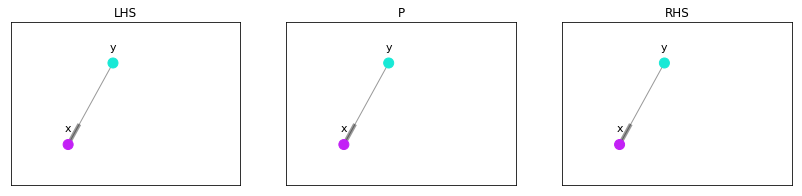

In [55]:
plot_rule(rule)

In [56]:
mm = h.access_graph('metaModel')
instances = mm.find_matching(pattern)
print("Instances: ", instances)

[('y', 'type', {'Child'}), ('y', 'name', {'Joe', 'Paul'})]
Instances:  [{'x': 'a', 'y': 'b'}]


In [57]:
#h.rewrite('metaModel', rule, instances[0])
h.rewrite('metaModel', rule, instances[0])

// Match nodes and edges of the instance 
MATCH (lhs_x:node:metaModel { id : 'a'}), (lhs_y:node:metaModel { id : 'b'}) , (lhs_y)-[lhs_y_lhs_x:edge]->(lhs_x), (lhs_y)-[lhs_y_lhs_y:edge]->(lhs_y)

// Renaming vars to correspond to the vars of P
WITH lhs_y_lhs_y, lhs_y_lhs_x , lhs_x as p_x, lhs_y as p_y 

// Removing properties from node 'y' of P 
FOREACH(dummy IN CASE WHEN 'name' IN keys(p_y) THEN [1] ELSE [] END |
SET p_y.name = filter(v in p_y.name WHERE NOT v IN ['Joe']))

// Removing properties from edge y->x of P 
WITH p_x, lhs_y_lhs_x, lhs_y_lhs_y, p_y MATCH (p_y)-[p_y_p_x:edge]->(p_x)
FOREACH(dummy IN CASE WHEN 'type' IN keys(p_y_p_x) THEN [1] ELSE [] END |
SET p_y_p_x.type = filter(v in p_y_p_x.type WHERE NOT v IN ['child_of']))

// Renaming vars to correspond to the vars of rhs
WITH p_y_p_x, lhs_y_lhs_x, lhs_y_lhs_y , p_x as rhs_x, p_y as rhs_y 

WITH [] as added_edges, p_y_p_x, rhs_y, lhs_y_lhs_x, lhs_y_lhs_y, rhs_x
// Return statement 
RETURN p_y_p_x, added_edges, rhs_y, lhs_y

<Record p_y_p_x=<Relationship id=39428 nodes=(<Node id=16596 labels={'metaModel', 'node'} properties={'name': ['Paul'], 'id': 'b', 'type': ['Child'], 'age': [11, 18, 10, 12]}>, <Node id=16583 labels={'metaModel', 'node'} properties={'type': ['Adult'], 'age': [43, 18, 35], 'id': 'a'}>) type='edge' properties={'type': []}> added_edges=[] rhs_y=<Node id=16596 labels={'metaModel', 'node'} properties={'name': ['Paul'], 'id': 'b', 'type': ['Child'], 'age': [11, 18, 10, 12]}> lhs_y_lhs_x=<Relationship id=39428 nodes=(<Node id=16596 labels={'metaModel', 'node'} properties={'name': ['Paul'], 'id': 'b', 'type': ['Child'], 'age': [11, 18, 10, 12]}>, <Node id=16583 labels={'metaModel', 'node'} properties={'type': ['Adult'], 'age': [43, 18, 35], 'id': 'a'}>) type='edge' properties={'type': []}> lhs_y_lhs_y=<Relationship id=39435 nodes=(<Node id=16596 labels={'metaModel', 'node'} properties={'name': ['Paul'], 'id': 'b', 'type': ['Child'], 'age': [11, 18, 10, 12]}>, <Node id=16596 labels={'metaModel'

In [58]:
h.propagation_up('metaModel')

Rewritting ancestors of metaModel...
-->  actionGraph
// Matching of the nodes to clone in 'actionGraph'
OPTIONAL MATCH (node_to_clone:node:actionGraph)-[t:typing]->(n:node:metaModel)
WITH node_to_clone, collect(n) as sucs, collect(t) as typ_sucs, size(collect(n)) as number_of_img
WHERE number_of_img >= 2 AND node_to_clone IS NOT NULL
FOREACH(t IN typ_sucs | DELETE t)
WITH node_to_clone, sucs, number_of_img-1 as number_of_clone
UNWIND range(1, number_of_clone) as clone_number
// create a node corresponding to the clone
CREATE (cloned_node:node:actionGraph) 
WITH cloned_node, toString(id(cloned_node)) as clone_id, node_to_clone.id as original_old, sucs, node_to_clone, clone_number 
// set the id property of the original node to NULL
SET node_to_clone.id = NULL
// copy all the properties of the original node to the clone
SET cloned_node = node_to_clone
// set id property of the clone to neo4j-generated id
SET cloned_node.id = toString(id(cloned_node)), cloned_node.count = NULL
// set bac

## Graph rewritting and propagation down

In [35]:
pattern = nx.DiGraph()
pattern.add_nodes_from([("w", {"name":{"Paul"}}), "x", "y", "z"])
pattern.add_edges_from([("x", "w"), ("y", "x"), ("y", "z"), ("z","z")])

In [36]:
rule = Rule.from_transform(pattern)
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "y")
rule.inject_add_edge("new_node", "x")
merged = rule.inject_merge_nodes(["w", "z"])

In [37]:
rule.inject_add_node_attrs("x", {"age":{10}})
rule.inject_add_edge_attrs("x", "z", {"relation":{"likes"}})

In [38]:
rule.added_node_attrs()

{'x': {'age': <regraph.default.attribute_sets.FiniteSet at 0x7ff0ee0cee48>},
 'w_z': {'name': <regraph.default.attribute_sets.FiniteSet at 0x7ff0ebcd1780>}}

/home/florian/Documents/Code/env3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecation

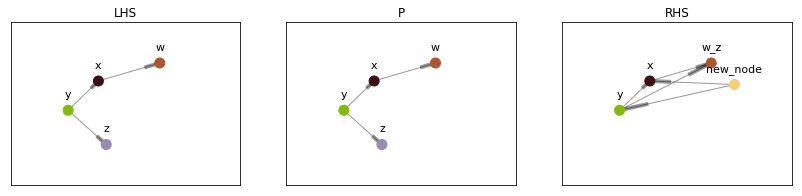

In [39]:
plot_rule(rule)

In [40]:
ag = h.access_graph('actionGraph')
instances = ag.find_matching(pattern)
print("Instances: ", instances)

[('w', 'name', {'Paul'})]
Instances:  []


In [41]:
#h.rewrite('actionGraph', rule, instances[1])
changes = h.rewrite('actionGraph', rule, instances[0])

IndexError: list index out of range

In [ ]:
h.propagation_down('actionGraph', changes)

In [ ]:
#h.propagation_down_v2('actionGraph', changes)

## Removing a graph from the hierarchy

We can also remove a graph from the hierarchy. All its nodes and connections (edges and typing edges) are removed.

In [ ]:
#h.remove_graph('MetaModel')

In [ ]:
#here we clear the hierarchy
h.clear()
h.close()
#